In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Running Pace Exploration

In this project, I'm going to investigate how different factors affect my running pace. Intuitively, runners know that things like elevation gain and temperature affect performance, but <i>how much</i>, exactly, does this affect pace?

Runs were logged with Strava, and heart rate data was collected using a Polar H10 chest strap over most of 2021.


# Strava Data

You can request all of your Strava user data from the Delete Account page (https://www.strava.com/athlete/delete_your_account). Summary statistics are located in activities.csv.

<b>Note:</b> Strava data is in SI units.


In [20]:
# Read in Strava statistics and find columns of interest
strava_df = pd.read_csv('activities_30Jan2022.csv', parse_dates=True, index_col='Activity Date')
#print(strava_df.columns)

From these categories, I'll need:

1. Average Speed
1. Average Heart Rate
1. Elevation Gain
1. Maximum Grade
1. Time Asleep

For all runs up to 1/30/22.

In [21]:
# Filter for only 2021 activities and later and runs only. Remove any rows with NaNs.
run_df = strava_df.sort_index().loc['2021-01-01':]
run_df = run_df[run_df['Activity Type'] == 'Run'][['Average Speed', 'Average Heart Rate', 'Elevation Gain', 'Max Grade']]
run_df = run_df.dropna()

# Let's also add units to the columns for completeness
run_df.columns = ['Average Speed (m/s)', 'Average Heart Rate (BPM)', 'Elevation Gain (m)', 'Max Grade (%)']

In [22]:
run_df.head()

Average Speed (m/s)  Average Heart Rate (BPM)  \
Activity Date                                                        
2021-01-11 19:57:21             2.116035                158.231827   
2021-01-13 20:36:58             2.447490                172.626175   
2021-01-19 00:05:15             2.104529                170.672272   
2021-01-22 23:50:27             2.295785                174.350204   
2021-01-26 00:05:07             2.457140                166.639969   

                     Elevation Gain (m)  Max Grade (%)  
Activity Date                                           
2021-01-11 19:57:21          173.881744      34.799999  
2021-01-13 20:36:58          165.052643      25.000000  
2021-01-19 00:05:15          501.487457      48.500000  
2021-01-22 23:50:27          298.129578      28.799999  
2021-01-26 00:05:07          301.950714      30.700001

In [23]:
# Convert average speed from km/h to mi/h
run_df['Average Speed (mi/h)'] = run_df['Average Speed (m/s)'] * 2.23694

# Convert elevation gain from m to ft
run_df['Elevation Gain (ft)'] = run_df['Elevation Gain (m)'] * 3.28084  

# Pace is a more common way of looking at running "speed"
run_df['Pace (minutes/mi)'] = 60 / run_df['Average Speed (mi/h)']

# Get rid of unnecessary columns
run_df.drop(['Average Speed (m/s)', 'Elevation Gain (m)', 'Average Speed (mi/h)'], axis=1, inplace=True) 

# In order to join the Strava DataFrame and the weather DataFrame, they need to have the same indicies.
# Both are currently DataTime objects, but the Strava data is more precise--all I care about is the year,
# month, and day an acvitivty occurred.
# I'm pretty sure I never ran more than once per day. In case I did, average the two runs.
run_df = run_df.resample('D').mean()
run_df = run_df.dropna()

In [24]:
run_df.head()

Average Heart Rate (BPM)  Max Grade (%)  Elevation Gain (ft)  \
Activity Date                                                                 
2021-01-11                   158.231827      34.799999           570.478182   
2021-01-13                   172.626175      25.000000           541.511313   
2021-01-19                   170.672272      48.500000          1645.300109   
2021-01-22                   174.350204      28.799999           978.115443   
2021-01-26                   166.639969      30.700001           990.651981   

               Pace (minutes/mi)  
Activity Date                     
2021-01-11             12.675762  
2021-01-13             10.959126  
2021-01-19             12.745065  
2021-01-22             11.683304  
2021-01-26             10.916089

# Sleep

In [25]:
# Sleep data 
sleep = pd.read_csv('AutoSleep.csv', parse_dates=True, index_col='toDate')
sleep = sleep.loc['2021-01-01':]
sleep = sleep[['asleep']]

# Need to convert the "asleep" column from hh:mm:ss to decimal hours
def to_hours(t):
    temp = t.split(':')
    
    # convert to hours
    hours = float(temp[0])
    minutes = float(temp[1]) / 60.0
    seconds = float(temp[2]) / 3600.0
    
    return hours + minutes + seconds

sleep['asleep'] = sleep['asleep'].apply(to_hours)
sleep.columns = ['Time Asleep (hours)']
sleep.head()

Time Asleep (hours)
toDate                         
2021-01-01             8.216667
2021-01-02             8.233333
2021-01-03             7.550000
2021-01-04             7.833333
2021-01-05             7.466667

# Rest Days

Rest days can be calculated by using .diff() on the Activity Date column.

In [26]:
'''
rest = run_df.reset_index()
dates = rest["Activity Date"]
rest = rest.diff()

rest["Days Rest"] = rest["Activity Date"].dt.days
rest["Days Rest"].iloc[0] = 0.0

#rest.set_index("Activity Date", inplace=True)
rest.drop(['Activity Date', 'Pace (minutes/mi)', 'Average Heart Rate (BPM)', 'Elevation Gain (ft)', 'Max Grade (%)'], axis=1, inplace=True)
rest["Activity Date"] = dates
rest.set_index("Activity Date", inplace=True)
'''

'\nrest = run_df.reset_index()\ndates = rest["Activity Date"]\nrest = rest.diff()\n\nrest["Days Rest"] = rest["Activity Date"].dt.days\nrest["Days Rest"].iloc[0] = 0.0\n\n#rest.set_index("Activity Date", inplace=True)\nrest.drop([\'Activity Date\', \'Pace (minutes/mi)\', \'Average Heart Rate (BPM)\', \'Elevation Gain (ft)\', \'Max Grade (%)\'], axis=1, inplace=True)\nrest["Activity Date"] = dates\nrest.set_index("Activity Date", inplace=True)\n'

# Weather Data

Weather data was obtained from http://www.ncdc.noaa.gov/cdo-web/search. For this exercise, I'm going to use the maximum temperature recorded in my city. I mostly run during daylight hours and within several hours of the hottest part of the day. That said, this is a major assumption, and I'd expect any effect of temperature to be an overprediction.  

In [27]:
# Read in NOAA data
weather_df = pd.read_csv('2818194.csv', parse_dates=True, index_col='DATE')
weather_df.columns

Index(['STATION', 'NAME', 'TMAX', 'TMIN'], dtype='object')

In [28]:
# Drop everything except TMAX and rename
weather_df.drop(['STATION', 'NAME', 'TMIN'], axis=1, inplace=True)
weather_df.columns = ['Maximum temperature (\u00B0F)']

In [29]:
weather_df.tail()

Maximum temperature (°F)
DATE                                
2022-01-26                        44
2022-01-27                        50
2022-01-28                        48
2022-01-29                        49
2022-01-30                        50

In [30]:
# Now, let's join the three DataFrames
all_df = run_df.join(weather_df, how='inner') 
all_df = all_df.join(sleep, how='inner')
all_df.head()

Average Heart Rate (BPM)  Max Grade (%)  Elevation Gain (ft)  \
2021-01-11                158.231827      34.799999           570.478182   
2021-01-13                172.626175      25.000000           541.511313   
2021-01-19                170.672272      48.500000          1645.300109   
2021-01-22                174.350204      28.799999           978.115443   
2021-01-26                166.639969      30.700001           990.651981   

            Pace (minutes/mi)  Maximum temperature (°F)  Time Asleep (hours)  
2021-01-11          12.675762                        51             8.916667  
2021-01-13          10.959126                        59             7.650000  
2021-01-19          12.745065                        52             9.116667  
2021-01-22          11.683304                        48             7.700000  
2021-01-26          10.916089                        38             7.433333

In [31]:
# Check for any missing data
all_df.isnull().values.any()

False

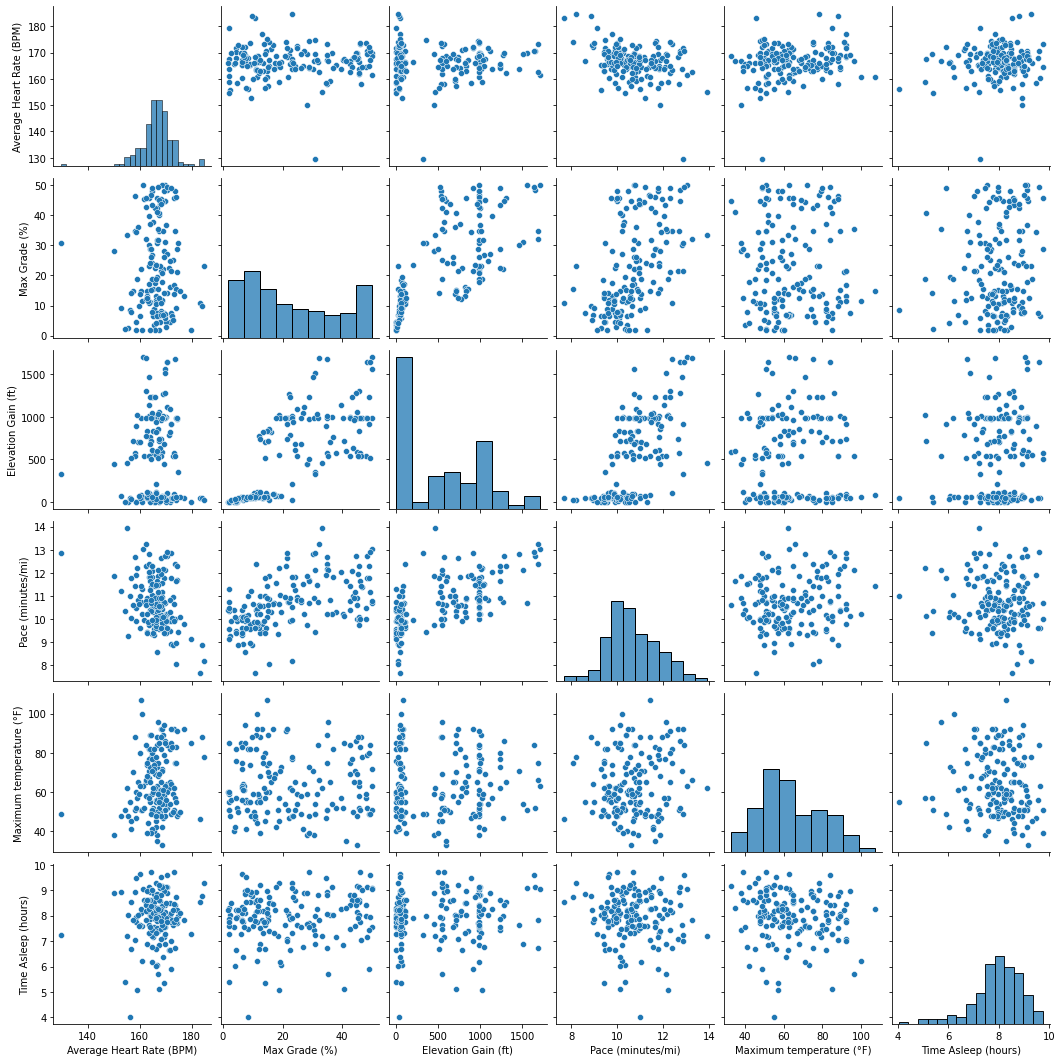

In [32]:
sns.pairplot(all_df)

# Correlation Heatmap

To get a quick idea of how much change in each variable is explained by another, I'll use a heatmap.

<AxesSubplot:>

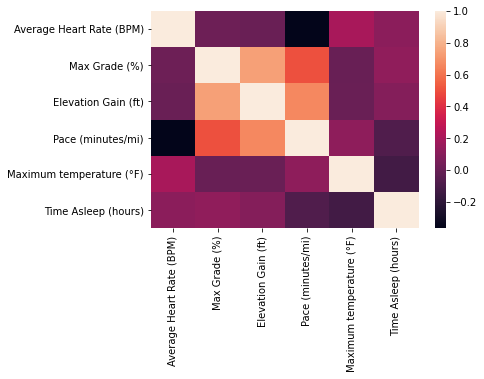

In [33]:
sns.heatmap(all_df.corr())

From the heatmap, it looks like pace and elevation gain have a strong positive correlation. Conversely, pace and average heart rate are slightly negatively correlated. Again, these all make intuitive sense to a runner. Let's quantify how much each feature actually affects another using a linear regression model.

In [38]:
# Try and predict pace 
X = all_df[['Average Heart Rate (BPM)', 'Elevation Gain (ft)', 'Maximum temperature (\u00B0F)', 'Max Grade (%)', 'Time Asleep (hours)']]
y = all_df['Pace (minutes/mi)']

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [40]:
from sklearn.linear_model import LinearRegression
import pickle

lm = LinearRegression()
lm.fit(X_train, y_train)

# Pickle model for widget
pickle.dump(lm, open("pace_30Jan2022.pkl", "wb"))

In [41]:
# Look at model's coefficients
coeff_df = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficient'])
coeff_df

Coefficient
Average Heart Rate (BPM)    -0.071062
Elevation Gain (ft)          0.001320
Maximum temperature (°F)     0.010058
Max Grade (%)                0.010741
Time Asleep (hours)         -0.071209

The units for the coefficients are in minutes/mile. Let's convert them to seconds/mile:

In [42]:
coeff_df * 60

Coefficient
Average Heart Rate (BPM)    -4.263749
Elevation Gain (ft)          0.079181
Maximum temperature (°F)     0.603500
Max Grade (%)                0.644483
Time Asleep (hours)         -4.272547

According to this model:
- An <b>increase of average heart rate of 1 BPM decreases average pace by 4.16 s</b>, holding all other features constant.
- For each <b>1 ft of elevation gain during the run, average pace increases by 0.09 s</b>, holding all other features constant.
- An <b>increase of 1°F of daily maximum temperature increases average pace by 0.98 s</b>, holding all other features constant.
- An <b>increase of 1% of the maximum grade increases average pace by 0.32 s</b>, holding all other features constant.
- An <b>increase of 1 hour to sleep decreases average pace by 4.27 s</b>, holding all other features constant.

# Predictions

0.6442551108021255

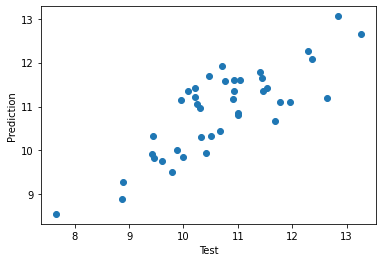

In [43]:
from sklearn.metrics import r2_score

# plot predictions and R^2
predictions = lm.predict(X_test)
plt.xlabel('Test')
plt.ylabel('Prediction')
plt.scatter(y_test, predictions)

r2_score(y_test, predictions)

$R^{2}=0.64$, meaning that 64% of the variation of average pace can be explained by average HR, elevation gain, max. temperature, and max. grade.

In [44]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.5413649263372485
MSE: 0.45774904999654153
RMSE: 0.6765715409301085


# Residuals

C:\Users\Zac\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Pace (minutes/mi)', ylabel='Density'>

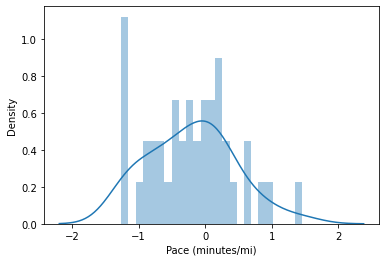

In [45]:
sns.distplot((y_test-predictions),bins=25)

With more training data, it looks like the residuals would approach a Gaussian distribution.

# Conclusions

* Add days since last run
* Add hours sleep from previous night
* Add Total distance
* endogenous variables